In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
#import plotly.express as px
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


# from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import os
# from keras.models import Model
from keras.optimizers import adam_v2
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np

In [ ]:
SEED = 12
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 46      #Was 46
EPOCHS = 10
LR =  0.001
NUM_CLASSES = 4
CLASS_LABELS = list(np.unique(labels))

In [ ]:
import os
from sklearn.model_selection import train_test_split

# Path ke folder data
data_dir = "/content/drive/MyDrive/Mangkat"

# Baca semua file dan label dari folder
file_paths = []
labels = []

for label_folder in os.listdir(data_dir):
    full_path = os.path.join(data_dir, label_folder)
    if os.path.isdir(full_path):
        for file_name in os.listdir(full_path):
            file_paths.append(os.path.join(full_path, file_name))
            labels.append(label_folder)

# Bagi data menjadi train dan test
train_files, test_files, train_labels, test_labels = train_test_split(
    file_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

# Contoh hasil pembagian
print(f"Train Files: {len(train_files)}, Test Files: {len(test_files)}")


Train Files: 1248, Test Files: 312


In [ ]:
train_df = pd.DataFrame({
    'filename': train_files,
    'class': train_labels
})

test_df = pd.DataFrame({
    'filename': test_files,
    'class': test_labels
})

In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input

# Gunakan fungsi preprocessing dari MobileNet
preprocess_fun = preprocess_input

# Data augmentation dan preprocessing menggunakan fungsi dari MobileNet
train_datagen = ImageDataGenerator(
                                   # horizontal_flip=True,
                                   # width_shift_range=0.1,
                                   # height_shift_range=0.05,
                                   preprocessing_function=preprocess_fun
                                  )
test_datagen = ImageDataGenerator(
                                  preprocessing_function=preprocess_fun
                                 )

val_datagen = ImageDataGenerator(
                                  preprocessing_function=preprocess_fun
                                 )


In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='class',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical',
    seed=SEED
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='class',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical',
    seed=SEED
)

Found 1248 validated image filenames belonging to 4 classes.
Found 312 validated image filenames belonging to 4 classes.


In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model

def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with MobileNet pretrained layers

    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """

    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = MobileNet(include_top=False,
                          weights='imagenet',
                          input_shape=input_shape)

    # Defines how many layers to freeze during training.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(1024, activation='relu')(top_model)  # Adjusted Dense layer size
    top_model = Dropout(0.5)(top_model)  # Increased dropout for better regularization
    output_layer = Dense(n_classes, activation='softmax')(top_model)

    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
input_shape = (224, 224, 3)
optim_1 = adam_v2.Adam(learning_rate=0.0001)
n_classes=4

n_steps = train_generator.samples // BATCH_SIZE
n_val_steps = test_generator.samples // BATCH_SIZE
n_epochs = 5

# First we'll train the model without Fine-tuning
vgg_model = create_model(input_shape=input_shape, optimizer=optim_1, fine_tune=5, n_classes=n_classes)

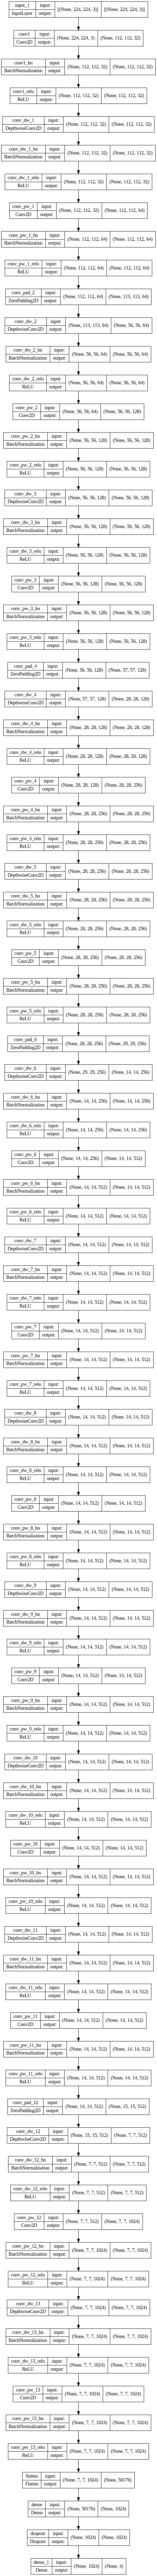

In [ ]:
from tensorflow.keras.utils import plot_model


# Visualisasikan arsitektur model
plot_model(vgg_model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


In [ ]:
# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='//content//drive//MyDrive//Model//moblinet_4.h5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

In [ ]:
%%time

vgg_history = vgg_model.fit(train_generator,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=test_generator,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_1, early_stop],
                            verbose=1)

Epoch 1/5
27/27 [==============================] - ETA: 0s - loss: 3.3087 - accuracy: 0.6215
Epoch 1: val_loss improved from inf to 0.47961, saving model to //content//drive//MyDrive//Model/moblinet_4.h5
27/27 [==============================] - 328s 12s/step - loss: 3.3087 - accuracy: 0.6215 - val_loss: 0.4796 - val_accuracy: 0.8768
Epoch 2/5
27/27 [==============================] - ETA: 0s - loss: 0.4553 - accuracy: 0.8844
Epoch 2: val_loss improved from 0.47961 to 0.38570, saving model to //content//drive//MyDrive//Model/moblinet_4.h5
27/27 [==============================] - 137s 5s/step - loss: 0.4553 - accuracy: 0.8844 - val_loss: 0.3857 - val_accuracy: 0.8804
Epoch 3/5
27/27 [==============================] - ETA: 0s - loss: 0.2220 - accuracy: 0.9326
Epoch 3: val_loss improved from 0.38570 to 0.19648, saving model to //content//drive//MyDrive//Model/moblinet_4.h5
27/27 [==============================] - 130s 5s/step - loss: 0.2220 - accuracy: 0.9326 - val_loss: 0.1965 - val_accura

In [ ]:
# Generate predictions
vgg_model.load_weights('//content//drive//MyDrive//Model//moblinet_4.h5') # initialize the best trained weights


true_classes = test_generator.classes
class_indices = test_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

vgg_preds = vgg_model.predict(test_generator)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)

vgg_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                    

In [ ]:
from sklearn.metrics import accuracy_score

vgg_acc = accuracy_score(true_classes, vgg_pred_classes)
print("VGG16 Model Accuracy without Fine-Tuning: {:.2f}%".format(vgg_acc * 100))

VGG16 Model Accuracy without Fine-Tuning: 93.91%


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(true_classes, vgg_pred_classes))

              precision    recall  f1-score   support

           0       0.97      0.91      0.94        78
           1       1.00      0.89      0.94        76
           2       0.96      1.00      0.98        80
           3       0.84      0.95      0.89        78

    accuracy                           0.94       312
   macro avg       0.94      0.94      0.94       312
weighted avg       0.94      0.94      0.94       312

